# France Road Accidents Exploratory Data Analysis

This notebook provides comprehensive exploratory data analysis of accidents using the `fct_accidents_hr` model.


## Setup


### Import

In [49]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

### Class Import

In [50]:
# Data Loader
from data_loader import DataLoader

In [4]:
# Read data from BigQuery

hr_table = 'biking-in-paris.accidents.fct_accidents_hr'

bike_only_query = f"""
        SELECT *,
               -- Add geographic scope categorization
               CASE 
                 WHEN department = '75' THEN 'Paris'
                 WHEN department IN ('75', '77', '78', '91', '92', '93', '94', '95') THEN 'Île-de-France'
                 ELSE 'Other France'
               END as geographic_scope
        FROM `{hr_table}`
        WHERE vehicle_category_cd IN (1, 50, 80)
        """

print("Filtering for vehicle types: 1 (Bicycle), 50 (E-personal transport motorized), 80 (E-bicycle)")

data_loader = DataLoader(custom_query=bike_only_query, target_table=hr_table)

df = data_loader.load_from_bigquery()

Filtering for vehicle types: 1 (Bicycle), 50 (E-personal transport motorized), 80 (E-bicycle)
Loading data using custom query...


/Users/zoe/Downloads/safe-biking-in-paris/ml_env/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 28,578 records from BigQuery


In [51]:
from severity_eda import SeverityEDA, PlotConfig

In [52]:
eda = SeverityEDA()

eda.set_data(df)

print(f"Vehicle types included: {df['vehicle_category_label'].unique()}")

Vehicle types included: ['Bicycle' 'E‑personal transport (motorized)' 'E‑bicycle']


## Analysis

In [53]:
eda.summary()


=== Severity overview ===
Fatality             |     893 cases |   3.1%
Hospitalized injury  |   5,926 cases |  20.7%
Minor injury         |  19,000 cases |  66.5%
Unharmed             |   2,741 cases |   9.6%
Unknown              |      18 cases |   0.1%
Total accidents: 28578


### Geographic: Paris, Île-de-France, Other France


=== Severity by geographic_scope ===

Other France (n=17,405)
  Fatality             |   4.7% (814)
  Hospitalized injury  |  29.8% (5,191)
  Minor injury         |  60.2% (10,484)
  Unharmed             |   5.2% (906)
  Unknown              |   0.1% (10)

Île-de-France (n=4,324)
  Fatality             |   1.4% (60)
  Hospitalized injury  |  10.6% (459)
  Minor injury         |  79.3% (3,428)
  Unharmed             |   8.6% (371)
  Unknown              |   0.1% (6)

Paris (n=6,849)
  Fatality             |   0.3% (19)
  Hospitalized injury  |   4.0% (276)
  Minor injury         |  74.3% (5,088)
  Unharmed             |  21.4% (1,464)
  Unknown              |   0.0% (2)


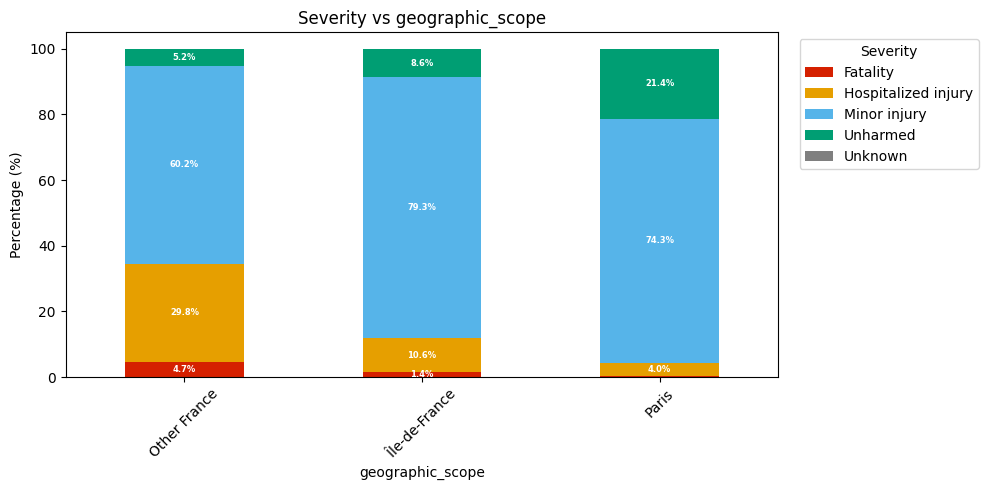

(severity_label    Fatality  Hospitalized injury  Minor injury   Unharmed  \
 geographic_scope                                                           
 Other France      4.676817            29.824763     60.235564   5.205401   
 Île-de-France     1.387604            10.615171     79.278446   8.580019   
 Paris             0.277413             4.029785     74.288217  21.375383   
 
 severity_label     Unknown  
 geographic_scope            
 Other France      0.057455  
 Île-de-France     0.138760  
 Paris             0.029201  ,
 severity_label    Fatality  Hospitalized injury  Minor injury  Unharmed  \
 geographic_scope                                                          
 Other France           814                 5191         10484       906   
 Paris                   19                  276          5088      1464   
 Île-de-France           60                  459          3428       371   
 
 severity_label    Unknown  
 geographic_scope           
 Other France         

In [54]:
eda.analyze("geographic_scope")

In [41]:
# define function to create heatmap
def create_heatmap(df, location, zoom_start, radius, blur):
    heat_map_df = df.copy()
    heat_map_df.dropna(subset=['latitude', 'longitude'], inplace=True)
    heat_map = folium.Map(location=location, zoom_start=zoom_start)
    heat_data = heat_map_df[['latitude', 'longitude']].values.tolist()
    HeatMap(
        heat_data,
        radius=radius,          
        blur=blur,           
        max_zoom=1,        
        gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}  
    ).add_to(heat_map)
    return heat_map

In [42]:
france_heat_map = create_heatmap(df, [46.2276, 2.2137], zoom_start=6, radius=6, blur=8)

france_heat_map

## IDF only

In [27]:
idf_df = df[(df['geographic_scope'] == 'Île-de-France') | (df['geographic_scope'] == 'Paris')]

In [28]:
idf_eda =  SeverityEDA()

idf_eda.set_data(idf_df)

In [29]:
idf_eda.summary()


=== Severity overview ===
Fatality             |      79 cases |   0.7%
Hospitalized injury  |     735 cases |   6.6%
Minor injury         |   8,516 cases |  76.2%
Unharmed             |   1,835 cases |  16.4%
Unknown              |       8 cases |   0.1%
Total accidents: 11173


In [45]:
idf_heat_map = create_heatmap(idf_df, [48.8566, 2.3522], zoom_start=12, radius=6, blur=8)

idf_heat_map

In [38]:
idf_severe_df = df[(df['severity_cd'] == 3) | (df['severity_cd'] == 2)]

idf_severe_df.head()

,user_id,accident_id,vehicle_id,user_role_cd,user_role_label,severity_cd,severity_label,gender_cd,gender_label,birth_year,...,number_of_lanes,public_transport_lane_cd,latitude,longitude,geom,accident_year,speed_limit_kmh,vehicles_in_accident,users_in_accident,geographic_scope
3,203 763 476,202300037000,155 614 981,1,Driver,3,Hospitalized injury,1,Male,1964,...,3,0,47.678838,-2.739855,POINT(-2.739855 47.678838),2023,50,2,2,Other France
12,203 790 096,202300025752,155 634 957,1,Driver,3,Hospitalized injury,1,Male,1984,...,2,0,49.358089,0.075989,POINT(0.075989 49.358089),2023,50,2,2,Other France
17,203 810 321,202300017185,155 650 119,1,Driver,2,Fatality,1,Male,1927,...,2,0,48.921952,2.294807,POINT(2.29480737 48.92195238),2023,50,2,2,Île-de-France
28,203 746 814,202300043930,155 602 652,1,Driver,3,Hospitalized injury,1,Male,1961,...,2,0,48.468248,-4.717292,POINT(-4.717292 48.468248),2023,80,2,2,Other France
29,203 751 465,202300042032,155 606 078,1,Driver,3,Hospitalized injury,1,Male,2006,...,2,0,49.037190,-1.231002,POINT(-1.231002 49.03719),2023,80,2,2,Other France


In [48]:
idf_severe_heat_map = create_heatmap(idf_severe_df, [48.8566, 2.3522], 
                                     zoom_start=12, radius=10, blur=12)

idf_severe_heat_map

### Temporal & Environmental


=== Severity by time_of_day_label ===

Night (n=1,053)
  Fatality             |   1.1% (12)
  Hospitalized injury  |   9.7% (102)
  Minor injury         |  78.8% (830)
  Unharmed             |  10.2% (107)
  Unknown              |   0.2% (2)

Off‑peak (n=4,635)
  Fatality             |   0.6% (29)
  Hospitalized injury  |   6.6% (308)
  Minor injury         |  75.0% (3,474)
  Unharmed             |  17.7% (822)
  Unknown              |   0.0% (2)

Evening peak (n=3,311)
  Fatality             |   0.5% (16)
  Hospitalized injury  |   6.2% (204)
  Minor injury         |  74.5% (2,468)
  Unharmed             |  18.8% (621)
  Unknown              |   0.1% (2)

Morning peak (n=2,174)
  Fatality             |   1.0% (22)
  Hospitalized injury  |   5.6% (121)
  Minor injury         |  80.2% (1,744)
  Unharmed             |  13.1% (285)
  Unknown              |   0.1% (2)


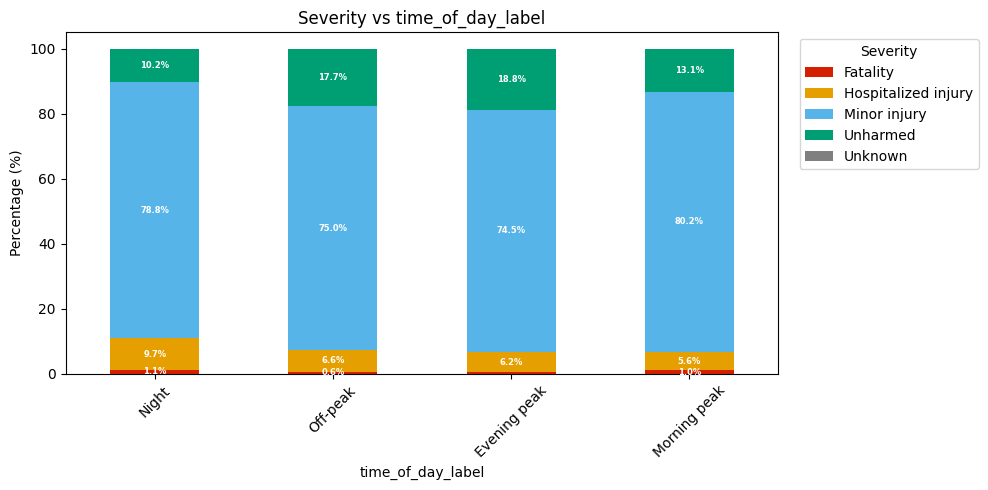


=== Severity by light_condition_label ===

Night – no lighting (n=109)
  Fatality             |   4.6% (5)
  Hospitalized injury  |  13.8% (15)
  Minor injury         |  65.1% (71)
  Unharmed             |  16.5% (18)
  Unknown              |   0.0% (0)

Night – lighting off (n=38)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  10.5% (4)
  Minor injury         |  81.6% (31)
  Unharmed             |   7.9% (3)
  Unknown              |   0.0% (0)

Night – lighting on (n=2,269)
  Fatality             |   1.1% (26)
  Hospitalized injury  |   7.8% (177)
  Minor injury         |  77.3% (1,754)
  Unharmed             |  13.7% (310)
  Unknown              |   0.1% (2)

Twilight / dawn (n=604)
  Fatality             |   0.8% (5)
  Hospitalized injury  |   7.0% (42)
  Minor injury         |  76.8% (464)
  Unharmed             |  15.4% (93)
  Unknown              |   0.0% (0)

Full daylight (n=8,153)
  Fatality             |   0.5% (43)
  Hospitalized injury  |   6.1% (497)
  Mino

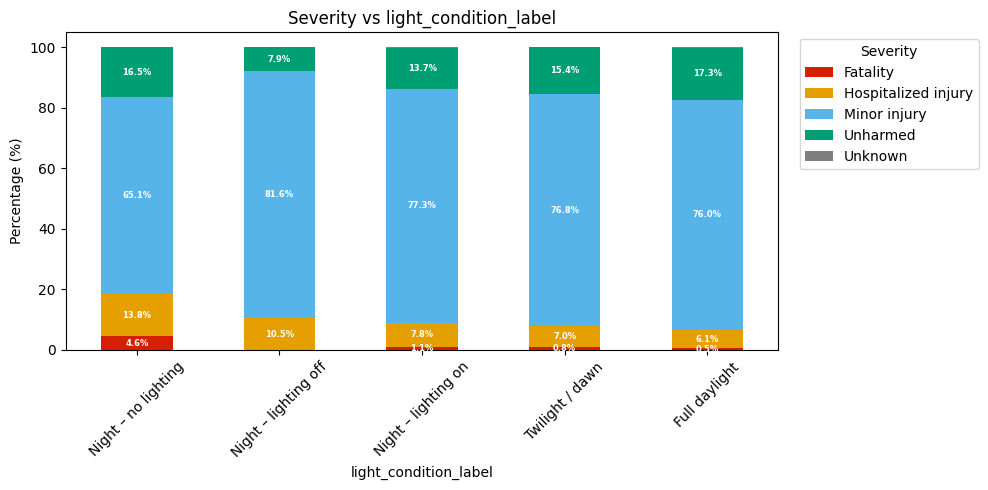


=== Severity by weather_condition_label ===

Snow or hail (n=8)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  37.5% (3)
  Minor injury         |  37.5% (3)
  Unharmed             |  25.0% (2)
  Unknown              |   0.0% (0)

Fog or smoke (n=3)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  33.3% (1)
  Minor injury         |  66.7% (2)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Strong wind / storm (n=11)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  27.3% (3)
  Minor injury         |  45.5% (5)
  Unharmed             |  27.3% (3)
  Unknown              |   0.0% (0)

Glare (n=95)
  Fatality             |   3.2% (3)
  Hospitalized injury  |   9.5% (9)
  Minor injury         |  73.7% (70)
  Unharmed             |  13.7% (13)
  Unknown              |   0.0% (0)

Heavy rain (n=148)
  Fatality             |   1.4% (2)
  Hospitalized injury  |  10.8% (16)
  Minor injury         |  75.7% (112)
  Unharmed          

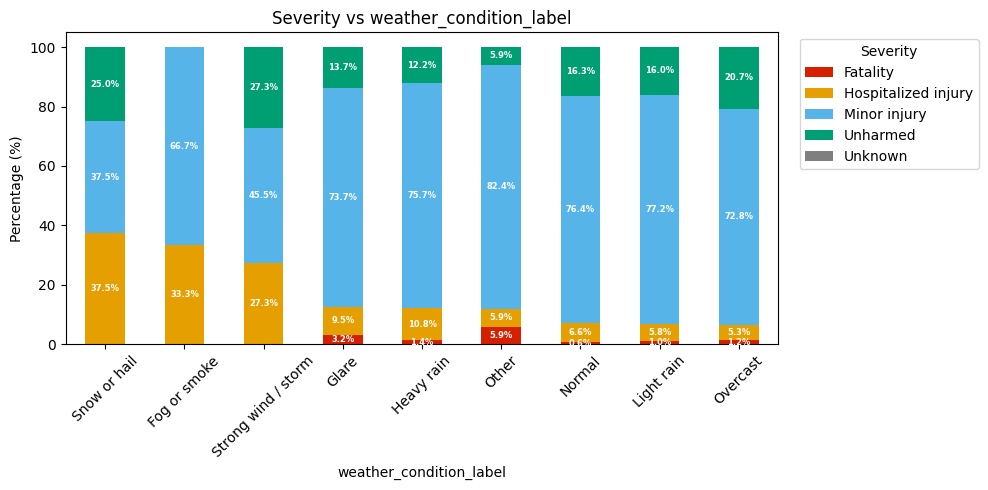


=== Severity by surface_condition_label ===

Mud (n=2)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  50.0% (1)
  Minor injury         |  50.0% (1)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Other (n=21)
  Fatality             |  14.3% (3)
  Hospitalized injury  |  19.0% (4)
  Minor injury         |  47.6% (10)
  Unharmed             |  19.0% (4)
  Unknown              |   0.0% (0)

Greasy / Oily (n=4)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  25.0% (1)
  Minor injury         |  75.0% (3)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Snow‑covered (n=4)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  25.0% (1)
  Minor injury         |  25.0% (1)
  Unharmed             |  50.0% (2)
  Unknown              |   0.0% (0)

Puddles (n=19)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  15.8% (3)
  Minor injury         |  52.6% (10)
  Unharmed             |  31.6% (6)
  Unkno

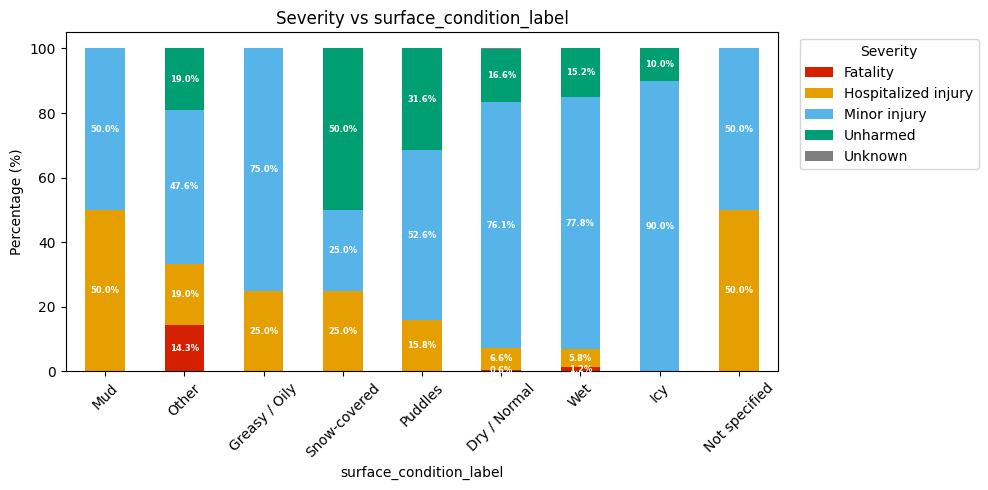

In [80]:
temporal_cols = [
    "time_of_day_label",      
    "light_condition_label",   
    "weather_condition_label", 
    "surface_condition_label"  
]

for col in temporal_cols:
    if col in df.columns:
        idf_eda.analyze(col)
        

### Infrastructure


=== Severity by infrastructure_label ===

Slip road / ramp (n=11)
  Fatality             |   9.1% (1)
  Hospitalized injury  |   9.1% (1)
  Minor injury         |  81.8% (9)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Roadworks (n=85)
  Fatality             |   1.2% (1)
  Hospitalized injury  |  11.8% (10)
  Minor injury         |  77.6% (66)
  Unharmed             |   9.4% (8)
  Unknown              |   0.0% (0)

Level crossing (n=16)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  12.5% (2)
  Minor injury         |  81.2% (13)
  Unharmed             |   6.2% (1)
  Unknown              |   0.0% (0)

Modified intersection (n=417)
  Fatality             |   1.2% (5)
  Hospitalized injury  |  10.1% (42)
  Minor injury         |  79.9% (333)
  Unharmed             |   8.9% (37)
  Unknown              |   0.0% (0)

Other (n=259)
  Fatality             |   1.9% (5)
  Hospitalized injury  |   8.5% (22)
  Minor injury         |  77.2% (200)
  Unharm

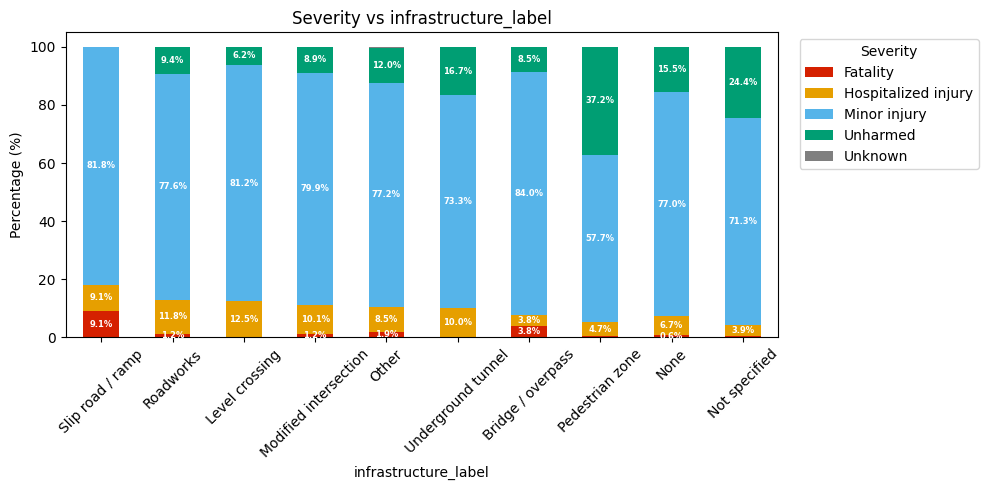


=== Severity by intersection_type_label ===

Roundabout (n=307)
  Fatality             |   0.3% (1)
  Hospitalized injury  |  14.3% (44)
  Minor injury         |  80.1% (246)
  Unharmed             |   5.2% (16)
  Unknown              |   0.0% (0)

Other (n=298)
  Fatality             |   0.3% (1)
  Hospitalized injury  |   9.4% (28)
  Minor injury         |  79.5% (237)
  Unharmed             |  10.4% (31)
  Unknown              |   0.3% (1)

Not at intersection (n=3,390)
  Fatality             |   1.0% (35)
  Hospitalized injury  |   8.3% (281)
  Minor injury         |  74.5% (2,526)
  Unharmed             |  16.1% (545)
  Unknown              |   0.1% (3)

> 4 branches (n=241)
  Fatality             |   1.2% (3)
  Hospitalized injury  |   5.8% (14)
  Minor injury         |  77.6% (187)
  Unharmed             |  15.4% (37)
  Unknown              |   0.0% (0)

Y‑intersection (n=509)
  Fatality             |   0.6% (3)
  Hospitalized injury  |   6.1% (31)
  Minor injury         |  70.

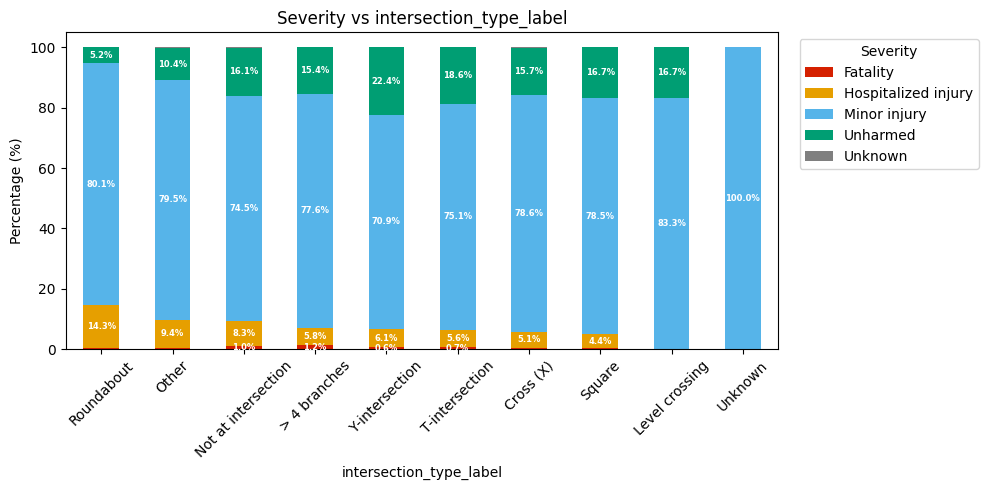


=== Severity by road_category_label ===

Outside public network (n=6)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  33.3% (2)
  Minor injury         |  66.7% (4)
  Unharmed             |   0.0% (0)
  Unknown              |   0.0% (0)

Public parking area (n=8)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  25.0% (2)
  Minor injury         |  62.5% (5)
  Unharmed             |  12.5% (1)
  Unknown              |   0.0% (0)

Other (n=32)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  21.9% (7)
  Minor injury         |  59.4% (19)
  Unharmed             |  18.8% (6)
  Unknown              |   0.0% (0)

National road (n=32)
  Fatality             |   0.0% (0)
  Hospitalized injury  |  12.5% (4)
  Minor injury         |  84.4% (27)
  Unharmed             |   3.1% (1)
  Unknown              |   0.0% (0)

Departmental road (n=2,515)
  Fatality             |   1.7% (42)
  Hospitalized injury  |  10.2% (257)
  Minor injury         |  80.4% (2,021)


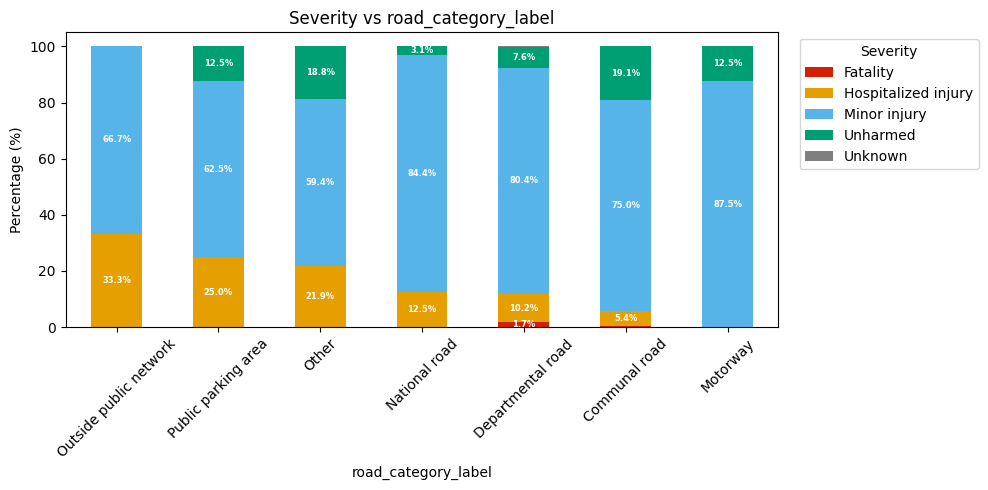


=== Severity by urban_area_label ===

Outside urban area (n=164)
  Fatality             |   6.7% (11)
  Hospitalized injury  |  31.1% (51)
  Minor injury         |  59.1% (97)
  Unharmed             |   3.0% (5)
  Unknown              |   0.0% (0)

Within urban area (n=11,009)
  Fatality             |   0.6% (68)
  Hospitalized injury  |   6.2% (684)
  Minor injury         |  76.5% (8,419)
  Unharmed             |  16.6% (1,830)
  Unknown              |   0.1% (8)


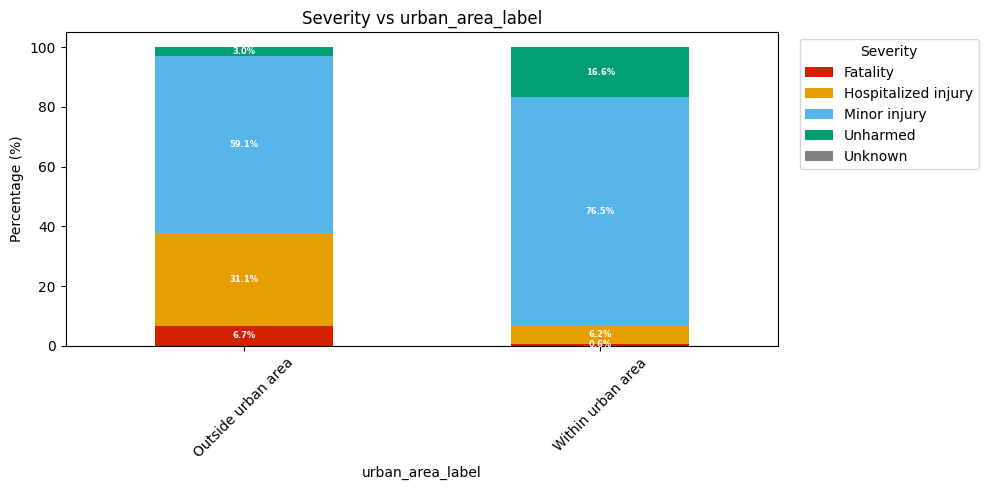

In [81]:
infrastructure_cols = [
    "infrastructure_label",    
    "intersection_type_label", 
    "road_category_label",     
    "urban_area_label"        
]

for col in infrastructure_cols:
    if col in df.columns:
        idf_eda.analyze(col)

### Personal 


=== Severity by age_group_label ===

Senior (n=461)
  Fatality             |   3.5% (16)
  Hospitalized injury  |  13.2% (61)
  Minor injury         |  79.4% (366)
  Unharmed             |   3.9% (18)
  Unknown              |   0.0% (0)

Older adult (n=1,635)
  Fatality             |   1.2% (19)
  Hospitalized injury  |   9.2% (150)
  Minor injury         |  80.9% (1,322)
  Unharmed             |   8.8% (144)
  Unknown              |   0.0% (0)

Child (n=285)
  Fatality             |   1.8% (5)
  Hospitalized injury  |   7.7% (22)
  Minor injury         |  78.2% (223)
  Unharmed             |  12.3% (35)
  Unknown              |   0.0% (0)

Youth (n=752)
  Fatality             |   0.5% (4)
  Hospitalized injury  |   7.2% (54)
  Minor injury         |  74.6% (561)
  Unharmed             |  17.7% (133)
  Unknown              |   0.0% (0)

Mid adult (n=2,646)
  Fatality             |   0.7% (19)
  Hospitalized injury  |   6.4% (170)
  Minor injury         |  81.0% (2,144)
  Unharmed     

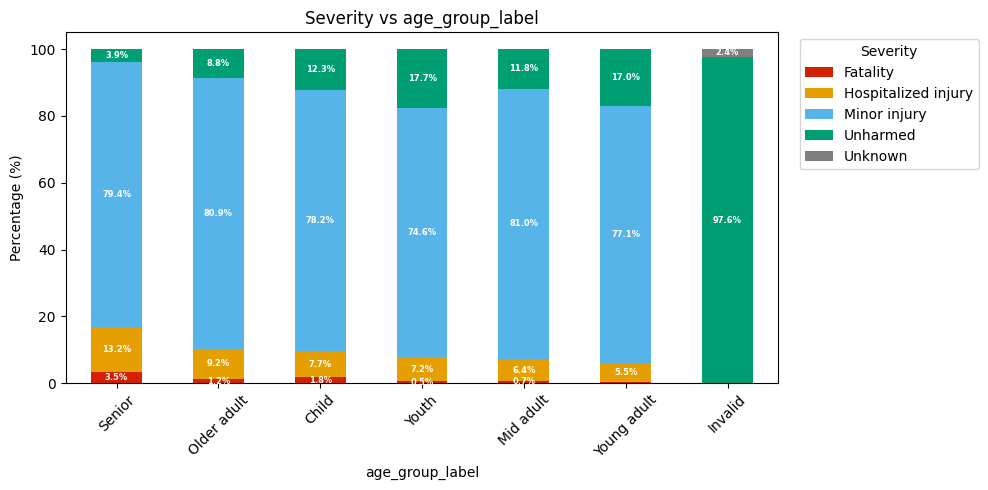


=== Severity by helmet_label ===

No helmet (n=7,125)
  Fatality             |   0.8% (54)
  Hospitalized injury  |   6.6% (468)
  Minor injury         |  74.9% (5,336)
  Unharmed             |  17.7% (1,259)
  Unknown              |   0.1% (8)

Wearing helmet (n=4,048)
  Fatality             |   0.6% (25)
  Hospitalized injury  |   6.6% (267)
  Minor injury         |  78.6% (3,180)
  Unharmed             |  14.2% (576)
  Unknown              |   0.0% (0)


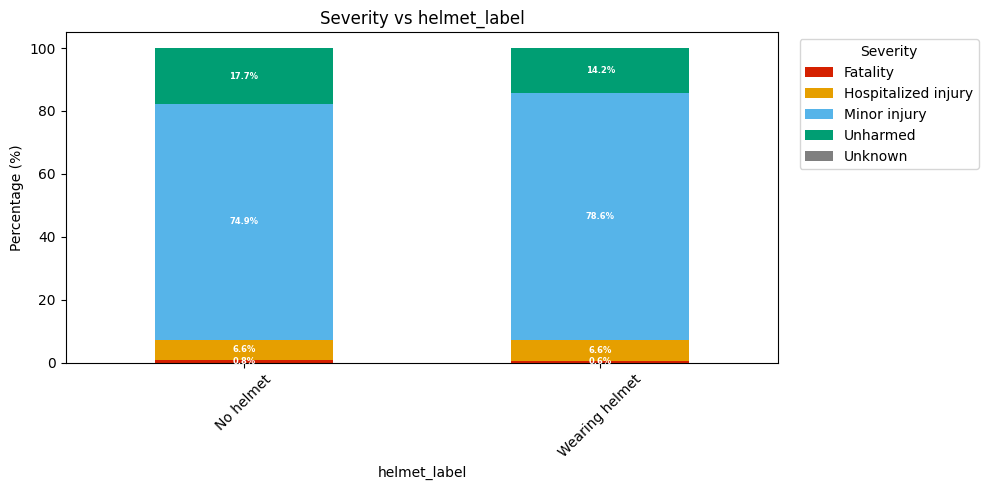


=== Severity by gender_label ===

Male (n=7,677)
  Fatality             |   0.8% (60)
  Hospitalized injury  |   7.3% (559)
  Minor injury         |  75.6% (5,801)
  Unharmed             |  16.4% (1,257)
  Unknown              |   0.0% (0)

Female (n=3,199)
  Fatality             |   0.6% (19)
  Hospitalized injury  |   5.5% (176)
  Minor injury         |  84.9% (2,715)
  Unharmed             |   9.0% (289)
  Unknown              |   0.0% (0)

Unknown (n=297)
  Fatality             |   0.0% (0)
  Hospitalized injury  |   0.0% (0)
  Minor injury         |   0.0% (0)
  Unharmed             |  97.3% (289)
  Unknown              |   2.7% (8)


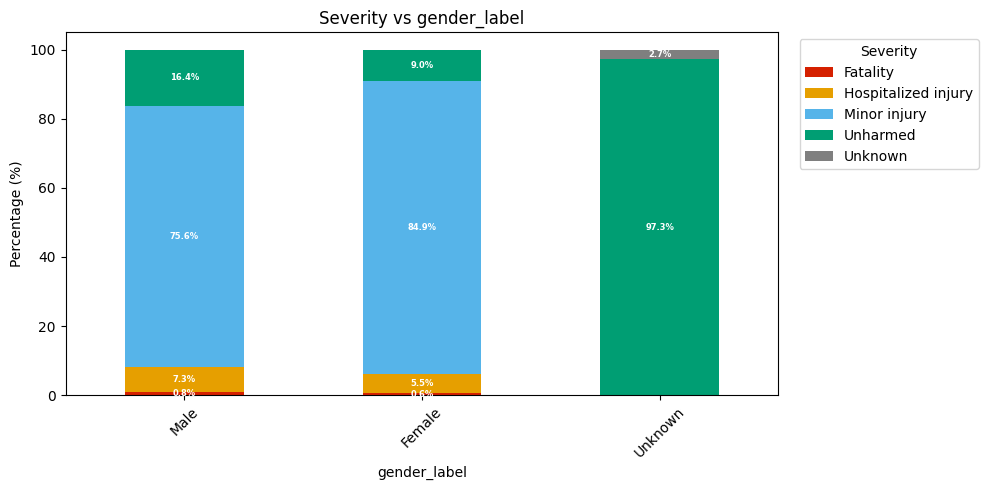


=== Severity by trip_purpose_label ===

Shopping (n=113)
  Fatality             |   3.5% (4)
  Hospitalized injury  |  12.4% (14)
  Minor injury         |  69.0% (78)
  Unharmed             |  15.0% (17)
  Unknown              |   0.0% (0)

Leisure (n=3,323)
  Fatality             |   0.9% (30)
  Hospitalized injury  |   7.5% (250)
  Minor injury         |  76.2% (2,532)
  Unharmed             |  15.4% (511)
  Unknown              |   0.0% (0)

Other (n=2,461)
  Fatality             |   0.5% (12)
  Hospitalized injury  |   6.7% (164)
  Minor injury         |  78.4% (1,930)
  Unharmed             |  14.4% (355)
  Unknown              |   0.0% (0)

Home–school (n=395)
  Fatality             |   0.8% (3)
  Hospitalized injury  |   6.3% (25)
  Minor injury         |  72.9% (288)
  Unharmed             |  20.0% (79)
  Unknown              |   0.0% (0)

Home–work (n=2,509)
  Fatality             |   0.5% (13)
  Hospitalized injury  |   5.2% (130)
  Minor injury         |  80.7% (2,024)
  Un

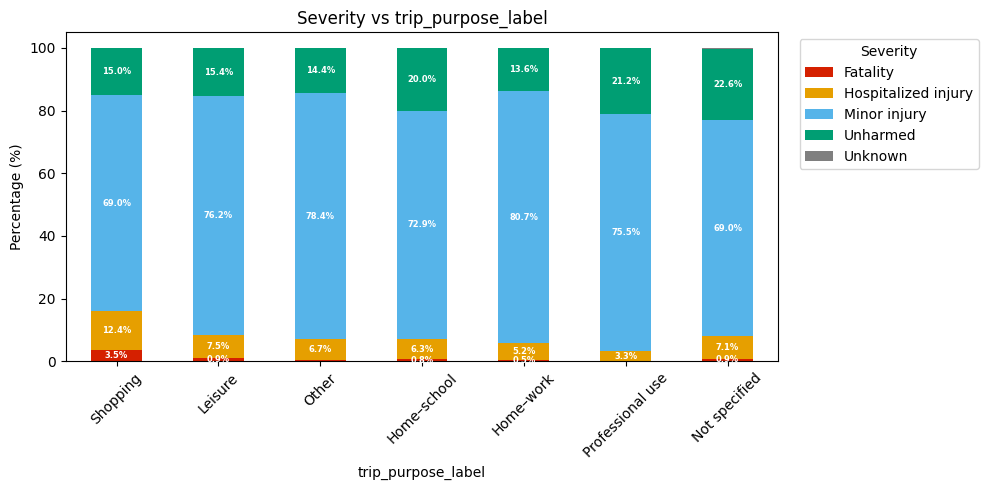


=== Severity by vehicle_category_label ===

E‑personal transport (motorized) (n=3,362)
  Fatality             |   0.8% (26)
  Hospitalized injury  |   7.7% (259)
  Minor injury         |  73.5% (2,470)
  Unharmed             |  18.0% (605)
  Unknown              |   0.1% (2)

E‑bicycle (n=1,106)
  Fatality             |   0.5% (6)
  Hospitalized injury  |   6.8% (75)
  Minor injury         |  76.1% (842)
  Unharmed             |  16.5% (182)
  Unknown              |   0.1% (1)

Bicycle (n=6,705)
  Fatality             |   0.7% (47)
  Hospitalized injury  |   6.0% (401)
  Minor injury         |  77.6% (5,204)
  Unharmed             |  15.6% (1,048)
  Unknown              |   0.1% (5)


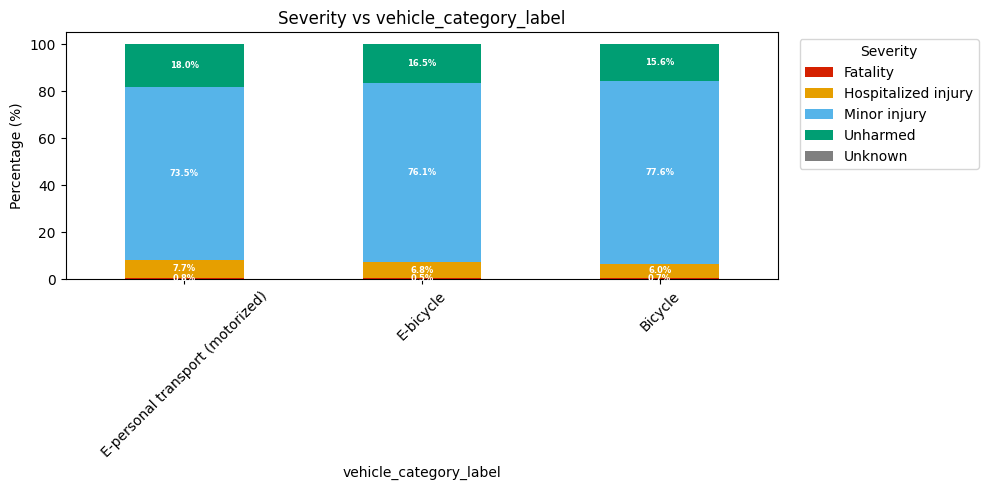

In [82]:
safety_cols = [
    "age_group_label",
    "helmet_label",             
    "gender_label",           
    "trip_purpose_label",     
    "vehicle_category_label" 
]

for col in safety_cols:
    if col in df.columns:
        idf_eda.analyze(col)

In [83]:
idf_df.head()

,user_id,accident_id,vehicle_id,user_role_cd,user_role_label,severity_cd,severity_label,gender_cd,gender_label,birth_year,...,public_transport_lane_cd,latitude,longitude,geom,accident_year,speed_limit_kmh,vehicles_in_accident,users_in_accident,geographic_scope,age_group
1,203 744 836,202300044748,155 601 169,1,Driver,4,Minor injury,2,Female,1989,...,2,48.883286,2.307296,POINT(2.307296 48.883286),2023,30,2,2,Paris,Over 25
4,203 749 500,202300042866,155 604 581,1,Driver,4,Minor injury,2,Female,1980,...,0,48.849312,2.281684,POINT(2.281684 48.849312),2023,50,2,2,Paris,Over 25
6,203 758 591,202300038995,155 611 428,1,Driver,4,Minor injury,2,Female,1978,...,3,48.864464,2.318964,POINT(2.318964 48.864464),2023,30,2,2,Paris,Over 25
8,203 759 224,202300038730,155 611 915,2,Passenger,1,Unharmed,2,Female,2010,...,0,48.885842,2.302529,POINT(2.302529 48.885842),2023,30,2,3,Paris,Under 15 / Other
9,203 767 800,202300035160,155 618 244,1,Driver,4,Minor injury,1,Male,1994,...,1,48.876335,2.355983,POINT(2.35598266 48.87633534),2023,30,1,1,Paris,Over 25


## Policy Suggestion: Helmet Usage Among Youth (15 - 25)

In [84]:

youth_young_adult_df = idf_df[(idf_df['age'] >= 15) & (idf_df['age'] <= 25)]

print("=== 15-25 Age Group Analysis ===")
print(f"Total accidents in 15-25 age group: {len(youth_young_adult_df):,}")
print(f"Percentage of total IDF accidents: {len(youth_young_adult_df)/len(idf_df)*100:.1f}%")
print()

# Overall helmet usage comparison
print("=== Helmet Usage Comparison ===")

# General population (IDF)
general_helmet_rate = idf_df['has_helmet'].mean()
general_total = len(idf_df)

# 15-25 age group
youth_helmet_rate = youth_young_adult_df['has_helmet'].mean()
youth_total = len(youth_young_adult_df)

print(f"General population (IDF):")
print(f"  Helmet usage rate: {general_helmet_rate:.3f} ({general_helmet_rate*100:.1f}%)")
print(f"  Sample size: {general_total:,}")
print()

print(f"15-25 age group:")
print(f"  Helmet usage rate: {youth_helmet_rate:.3f} ({youth_helmet_rate*100:.1f}%)")
print(f"  Sample size: {youth_total:,}")
print()

# Calculate the difference
helmet_rate_diff = youth_helmet_rate - general_helmet_rate
print(f"Difference: {helmet_rate_diff:+.3f} ({helmet_rate_diff*100:+.1f} percentage points)")
print()

# Helmet usage by severity for 15-25 age group
print("=== Helmet Usage by Severity (15-25 Age Group) ===")
youth_severity_helmet = youth_young_adult_df.groupby('severity_label').agg({
    'has_helmet': ['count', 'sum', 'mean']
}).round(3)

youth_severity_helmet.columns = ['Total_Cases', 'Helmet_Users', 'Helmet_Rate']
youth_severity_helmet['No_Helmet'] = youth_severity_helmet['Total_Cases'] - youth_severity_helmet['Helmet_Users']
youth_severity_helmet['Helmet_Pct'] = youth_severity_helmet['Helmet_Rate'] * 100

print(youth_severity_helmet)
print()

# Helmet usage by severity for general population (for comparison)
print("=== Helmet Usage by Severity (General IDF Population) ===")
general_severity_helmet = idf_df.groupby('severity_label').agg({
    'has_helmet': ['count', 'sum', 'mean']
}).round(3)

general_severity_helmet.columns = ['Total_Cases', 'Helmet_Users', 'Helmet_Rate']
general_severity_helmet['No_Helmet'] = general_severity_helmet['Total_Cases'] - general_severity_helmet['Helmet_Users']
general_severity_helmet['Helmet_Pct'] = general_severity_helmet['Helmet_Rate'] * 100

print(general_severity_helmet)
print()

# Statistical analysis: severity rates by helmet usage in 15-25 group
print("=== Severity Analysis by Helmet Usage (15-25 Age Group) ===")
youth_helmet_severity = youth_young_adult_df.groupby('has_helmet')['severity_label'].value_counts(normalize=True).unstack(fill_value=0)
youth_helmet_severity_pct = (youth_helmet_severity * 100).round(1)

print("Severity distribution by helmet usage (percentages):")
print(youth_helmet_severity_pct)
print()

# Calculate severe injury rates (Fatality + Hospitalized injury)
youth_severe_by_helmet = youth_young_adult_df.copy()
youth_severe_by_helmet['is_severe'] = youth_severe_by_helmet['severity_label'].isin(['Fatality', 'Hospitalized injury'])

severe_analysis = youth_severe_by_helmet.groupby('has_helmet').agg({
    'is_severe': ['count', 'sum', 'mean']
}).round(3)

severe_analysis.columns = ['Total', 'Severe_Cases', 'Severe_Rate']
severe_analysis = severe_analysis.reindex([0, 1], fill_value=0)
severe_analysis['Severe_Pct'] = severe_analysis['Severe_Rate'] * 100

print("Severe injury rates (Fatality + Hospitalized injury):")
print(severe_analysis)
print()

# Protection effect calculation
if len(severe_analysis) >= 2:
    no_helmet_rate = severe_analysis.iloc[0]['Severe_Rate']
    helmet_rate = severe_analysis.iloc[1]['Severe_Rate'] 
    
    protection_effect = no_helmet_rate - helmet_rate
    protection_pct = (protection_effect / no_helmet_rate) * 100 if no_helmet_rate > 0 else 0
    
    print(f"Helmet protection effect in 15-25 age group:")
    print(f"  No helmet severe injury rate: {no_helmet_rate:.3f} ({no_helmet_rate*100:.1f}%)")
    print(f"  With helmet severe injury rate: {helmet_rate:.3f} ({helmet_rate*100:.1f}%)")
    print(f"  Absolute risk reduction: {protection_effect:.3f} ({protection_effect*100:.1f} percentage points)")
    print(f"  Relative risk reduction: {protection_pct:.1f}%")
else:
    print("Insufficient data for protection effect calculation")


=== 15-25 Age Group Analysis ===
Total accidents in 15-25 age group: 2,855
Percentage of total IDF accidents: 25.6%

=== Helmet Usage Comparison ===
General population (IDF):
  Helmet usage rate: 0.362 (36.2%)
  Sample size: 11,173

15-25 age group:
  Helmet usage rate: 0.256 (25.6%)
  Sample size: 2,855

Difference: -0.107 (-10.7 percentage points)

=== Helmet Usage by Severity (15-25 Age Group) ===
                     Total_Cases  Helmet_Users  Helmet_Rate  No_Helmet  \
severity_label                                                           
Fatality                       4             1         0.25          3   
Hospitalized injury          169            30        0.178        139   
Minor injury                2125           548        0.258       1577   
Unharmed                     557           151        0.271        406   

                     Helmet_Pct  
severity_label                   
Fatality                   25.0  
Hospitalized injury        17.8  
Minor injury   

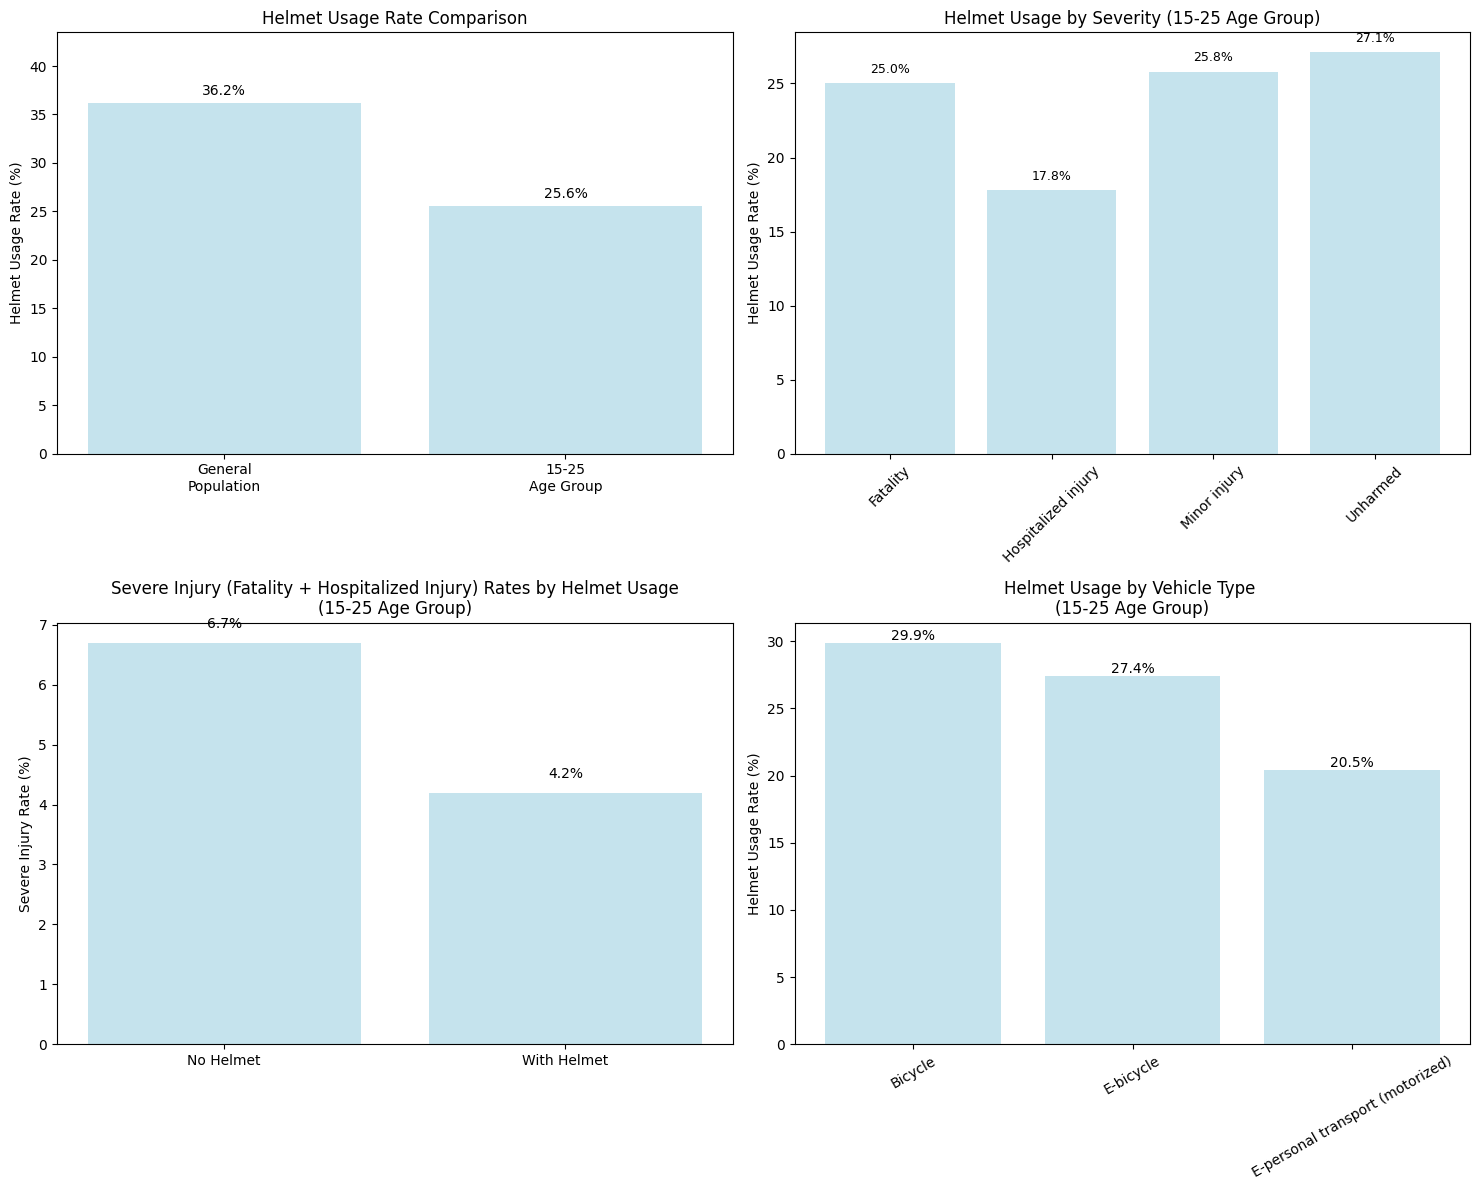

In [85]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall helmet usage comparison
ax1 = axes[0, 0]
categories = ['General\nPopulation', '15-25\nAge Group']
helmet_rates = [general_helmet_rate * 100, youth_helmet_rate * 100]
colors = ['lightblue', 'lightblue']

bars1 = ax1.bar(categories, helmet_rates, color=colors, alpha=0.7)
ax1.set_ylabel('Helmet Usage Rate (%)')
ax1.set_title('Helmet Usage Rate Comparison')
ax1.set_ylim(0, max(helmet_rates) * 1.2)

# Add value labels on bars
for bar, rate in zip(bars1, helmet_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rate:.1f}%', ha='center', va='bottom')

# 2. Helmet usage by severity (15-25 age group)
ax2 = axes[0, 1]
severity_order = ['Fatality', 'Hospitalized injury', 'Minor injury', 'Unharmed']
available_severities = [s for s in severity_order if s in youth_severity_helmet.index]

helmet_pcts = [youth_severity_helmet.loc[s, 'Helmet_Pct'] if s in youth_severity_helmet.index else 0 
               for s in available_severities]

bars2 = ax2.bar(available_severities, helmet_pcts, color='lightblue', alpha=0.7)
ax2.set_ylabel('Helmet Usage Rate (%)')
ax2.set_title('Helmet Usage by Severity (15-25 Age Group)')
ax2.tick_params(axis='x', rotation=45)

for bar, pct in zip(bars2, helmet_pcts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. Severe injury rates by helmet usage
ax3 = axes[1, 0]
helmet_labels = ['No Helmet', 'With Helmet']
severe_rates = [severe_analysis.loc[0, 'Severe_Pct'], severe_analysis.loc[1, 'Severe_Pct']]
colors3 = ['lightblue', 'lightblue']

bars3 = ax3.bar(helmet_labels, severe_rates, color=colors3, alpha=0.7)
ax3.set_ylabel('Severe Injury Rate (%)')
ax3.set_title('Severe Injury (Fatality + Hospitalized Injury) Rates by Helmet Usage\n(15-25 Age Group)')

for bar, rate in zip(bars3, severe_rates):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{rate:.1f}%', ha='center', va='bottom')

# 4. helmet usage by vehicle type
ax4 = axes[1, 1]
helmet_by_vehicle = youth_young_adult_df.groupby('vehicle_category_label')['has_helmet'].mean().sort_values(ascending=False) * 100
bars4 = ax4.bar(helmet_by_vehicle.index, helmet_by_vehicle.values, alpha=0.7, color='lightblue')
ax4.set_ylabel('Helmet Usage Rate (%)')
ax4.set_title('Helmet Usage by Vehicle Type \n(15-25 Age Group)')
ax4.tick_params(axis='x', labelrotation=30)

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
